In [38]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as tfs

from matplotlib.colors import ListedColormap

import os
import pandas as pd
from torchvision.io import read_image
from pathlib import Path
import imagesize
from dataclasses import dataclass
from PIL import Image
from torchvision.transforms import ToTensor
from functools import lru_cache
from datetime import datetime
import time

In [39]:
@dataclass(init=True, eq=True)
class Rectangle:
    x: int
    y: int
    width: int
    height: int
        
class InriaImageDataset(Dataset):
    def __init__(
        self, 
        base_path, 
        img_dir, 
        label_dir, 
        transform=None, 
        target_transform=None, 
        max_size=None, 
        size_floor=True,
        load=False,
        debug=False,
        crop_tensor=False,
    ):
        self.debug = debug
        self.base_path = Path(base_path)
        print('Preparing dataset in', self.base_path)
        self.img_dir = self.base_path / img_dir
        print('Images directory', self.img_dir)
        self.label_dir = self.base_path / label_dir
        print('Labels directory', self.label_dir)
        self.to_tensor =  ToTensor()
        self.transform = transform
        self.target_transform = target_transform
        self.max_size = max_size
        
        image_names = os.listdir(self.img_dir)
        label_names = os.listdir(self.label_dir)
        assert image_names == label_names
        print('Total images =', len(image_names))
        
        self.image_names = image_names

        self.index_to_image_and_rect = []

        for img_name in self.image_names:
            width, height = imagesize.get(self.img_dir / img_name)
            if max_size:
                max_width, max_height = max_size
            else:
                max_width, max_height = width, height

            for wi in range(width // max_width):
                for hi in range(height // max_height):
                    rect = Rectangle(x=wi, y=hi, width=max_width, height=max_height)
                    self.index_to_image_and_rect.append((img_name, rect))
            # todo % rest
        print('Total crops =', len(self.index_to_image_and_rect))
        
        if load:
            set_len = len(self.image_names) + len(label_names)
            print('Loading in memory', set_len, "images")
            for i, (img_name, label_name) in enumerate(zip(self.image_names, label_names)):
                self._get_image(self.img_dir / img_name)
                self._get_image(self.label_dir / label_name)
                print('Loaded', i*2, "/", set_len)
        if crop_tensor:
            self.get_crop = self._get_crop_tensor
        else:
            self.get_crop = self._get_crop_image

    def __len__(self):
        return len(self.index_to_image_and_rect)

#     @lru_cache(maxsize=400)
    def _get_image(self, path):
        if self.debug:
            print('open', path)
        start = time.time()
        image = Image.open(path)
        if self.debug:
            print('Read time', time.time() - start)
        return image
    
#     @lru_cache(maxsize=400)
    def _crop_tensor(self, path, size):
        image = self._get_image(path)
        image = self.to_tensor(image)
        start = time.time()
        mw, mh = size
        c, w, h = image.shape
        cropw = [*(i*mw for i in range(1, w // mw)), w-(w % mw)]
        croph = [*(i*mh for i in range(1, h // mh)), h-(h % mh)]

        crop_map = {}
        vert_splits = torch.tensor_split(image, cropw, dim=2)
        x, y = 0, 0
        for vert_split in vert_splits:
            for split in torch.tensor_split(vert_split, croph, dim=1):
                _, w, h = split.shape
                if w < mw or h < mh:
                    continue
                crop_map[(x, y)] = split
                y += 1
            x += 1
            y = 0
        if self.debug:
            print('Crop time',  time.time() - start)
        return crop_map
    
    def _get_crop_tensor(self, path, crop_rect):
        start = time.time()
        size = (crop_rect.width, crop_rect.height)
        crop_map = self._crop_tensor(path, size)
        image = crop_map[(crop_rect.x, crop_rect.y)]
        if self.debug:
            print('Crop tensor first time',  time.time() - start)
        return image
    
    def _get_crop_image(self, path, crop_rect):
        start = time.time()
        image = self._get_image(path)
        x, y = crop_rect.x * crop_rect.width, crop_rect.y * crop_rect.height
        size = (x, y, x + crop_rect.width, y + crop_rect.height)
        image = image.crop(size)
        image = self.to_tensor(image)
        if self.debug:
            print('Crop image first time',  time.time() - start)
        return image

    def get_image_name_by_idx(self, idx):
        img_name, rect = self.index_to_image_and_rect[idx]
        return img_name

    def __getitem__(self, idx):
        if self.debug:
            print('idx', idx)
        img_name, rect = self.index_to_image_and_rect[idx]
        img_path = self.img_dir / img_name
        label_path = self.label_dir / img_name
        
        image = self.get_crop(img_path, rect)
        label = self.get_crop(label_path, rect)
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [40]:
start = time.time()

# max_size=(128, 128)
max_size=(512, 512)
# max_size=(5000, 5000)
batch_size=8

print('Using max_size =', max_size)
train_dataset = InriaImageDataset("/home/s0011/data_inria/train", img_dir="images", label_dir="gt", max_size=max_size, load=False, debug=False, crop_tensor=False)
test_dataset = InriaImageDataset("/home/s0011/data_inria/validation", img_dir="images", label_dir="ground_truth", max_size=max_size)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

end = time.time()
print("Preparing time", end - start)

Using max_size = (512, 512)
Preparing dataset in /home/s0011/data_inria/train
Images directory /home/s0011/data_inria/train/images
Labels directory /home/s0011/data_inria/train/gt
Total images = 180
Total crops = 14580
Preparing dataset in /home/s0011/data_inria/validation
Images directory /home/s0011/data_inria/validation/images
Labels directory /home/s0011/data_inria/validation/ground_truth
Total images = 25
Total crops = 2025
Preparing time 0.22445344924926758


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


for cmap in [
    plt.get_cmap(), plt.get_cmap('turbo'), *[plt.get_cmap(n) for n in ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r']]
]:
    ncolors = 256
    color_array = cmap(range(ncolors))
    color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
    map_object = LinearSegmentedColormap.from_list(name=f'transparent_{cmap.name}',colors=color_array)
    plt.register_cmap(cmap=map_object)


cmap = plt.get_cmap()
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)

def tensor_to_image(t):
    return t.permute(2,1,0).squeeze()

def plot_lineup(im, ms, gt, figsize=None, ax=None):
    if not figsize:
        figsize = (20,20)
    if not ax:
        fig, ax = plt.subplots(figsize = figsize)

    img = ax.imshow(im, interpolation='nearest', origin='lower')
    img = ax.imshow(gt,
#                     interpolation='nearest', 
                    origin='lower', 
                    alpha=0.5, 
                    cmap='transparent_viridis')
    img = ax.imshow(ms, 
#                     interpolation='nearest', 
                    alpha=0.5, 
                    origin='lower',
                    cmap='transparent_BuPu',
                   )
    
def dataset_samples(dataset):
    print("Dataset size =", len(dataset))
    figure = plt.figure(figsize=(20, 20))
    cols, rows = 2, 2
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        name = dataset.get_image_name_by_idx(sample_idx)
        figure.add_subplot(rows, cols, i)
        plt.imshow(tensor_to_image(img), interpolation='nearest', origin='lower')
        plt.imshow(tensor_to_image(label), interpolation='nearest', alpha=0.5, origin='lower', cmap=my_cmap)
        plt.title(name)
    plt.show()

In [37]:
dataset_samples(train_dataset)

Dataset size = 14580


AttributeError: 'float' object has no attribute 'time'

<Figure size 1440x1440 with 0 Axes>

In [ ]:
dataset_samples(test_dataset)

# Model

# Simple encoder

In [5]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
#         x = torch.relu(torch.sign(x-0.5))

        return x
    
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [6]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-10):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()

        total = (inputs + targets).sum()

        union = total - intersection 

        IoU = (intersection + smooth)/(union + smooth)
    
        return 1 - IoU

In [7]:
criterion = IoULoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "test": test_dataloader}

# Unet

In [8]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = tfs.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=max_size):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [9]:
model = UNet()
criterion = IoULoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "test": test_dataloader}

# Unet 2

In [10]:
import segmentation_models_pytorch as smp

get_model = lambda: smp.Unet(
    encoder_name="efficientnet-b0",
#     encoder_weights="imagenet",
    encoder_depth = 3,
#     encoder_weights = None,
#     decoder_use_batchnorm: bool = True,
    decoder_channels = (64, 32, 16),
    in_channels=3,
    classes=1,
)
model = get_model()
criterion = IoULoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "test": test_dataloader}

In [11]:
# for param in model.parameters():
#     print(type(param.data), param.size())
print(sum(p.numel() for p in model.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

4125645
4125645
Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
    

In [12]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K40m
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/home/s0011/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


In [13]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
device = 'cpu'
print(device)
model.to(device)

cpu


Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_

In [14]:
def save(model, optimizer, path, epoch, loss, train_time):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'train_time': train_time,
    }, path)

In [22]:
!ls saves/first_try_2022-03-31_00:30:51.565176

'model-e1-1|1823.pth'


In [27]:
from itertools import islice

session_prefix = "first_try"

date = str(datetime.now()).replace(" ", "_")
path = Path("/misc/home1/s0011/segmentim/saves")
model_dir = path / f"{session_prefix}_{date}"
os.mkdir(model_dir)

n_epochs = 1
save_every = 1

end = 0
losses = {}
data_n = 0
begin_time = time.time()
model.train()
total_data = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    losses[epoch] = []
    for images, labels in islice(train_dataloader, 2):
        start = time.time()
        print('Iteration time', start - end)
        
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses[epoch].append(loss.item())
        print('Epoch: {} {}\nLoss {:.6f}'.format(epoch, data_n, loss))
        
        end = time.time()
        print("Batch time", end - start, '\n')
        data_n += 1
        if data_n % save_every == 0:
            model_path = model_dir/f"model-epoch{epoch}-train{data_n}|{total_data}.pth"
            print('Saving into', model_path)
            save(model, optimizer, model_path, epoch, loss, begin_time - time.time())

    train_loss = train_loss/len(train_dataloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


Iteration time 1648668967.9089913
Epoch: 1 0
Loss 0.279198
Batch time 17.744818210601807 

Saving into /misc/home1/s0011/segmentim/saves/first_try_2022-03-31_00:36:04.919854/model-epoch1-train1|1823.pth
Iteration time 0.0872037410736084
Epoch: 1 1
Loss 0.632568
Batch time 8.299179077148438 

Saving into /misc/home1/s0011/segmentim/saves/first_try_2022-03-31_00:36:04.919854/model-epoch1-train2|1823.pth
Epoch: 1 	Training Loss: 0.000000


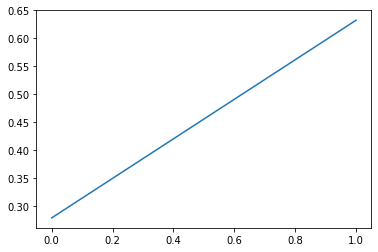

In [28]:
plt.plot(losses[1])

In [29]:
from os import listdir
from os.path import isfile, join
model_saves = [f for f in listdir(model_dir) if isfile(join(model_dir, f))]
print(model_saves)

['model-epoch1-train2|1823.pth', 'model-epoch1-train1|1823.pth']


In [30]:
model_save = sorted(model_saves)[0]

In [31]:
model = get_model()

criterion = IoULoss()
optimizer = torch.optim.Adam(model.parameters())

checkpoint = torch.load(model_dir / model_save)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
train_time = checkpoint['train_time']

In [43]:
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 
    
#Batch of test images
dataiter = iter(test_dataloader)

In [44]:
images, labels = dataiter.next()

Reconstructed Images


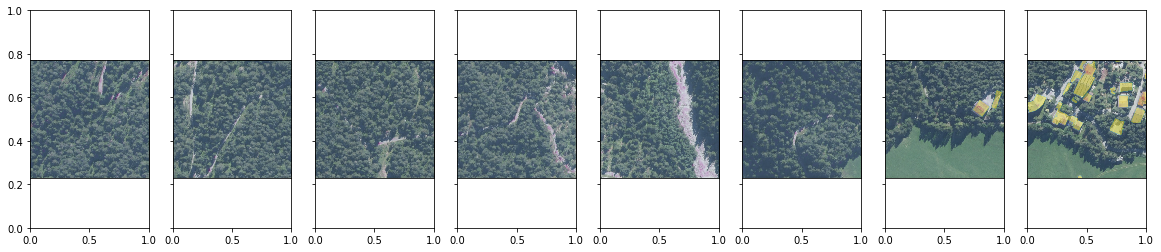

Outputs


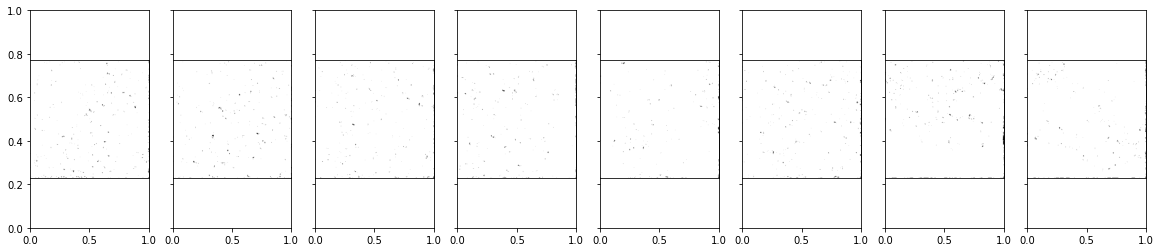

In [45]:
#Sample outputs
with torch.no_grad():
    output = model(images)
#     output = F.sigmoid(output)
# images = images.numpy()

# output = output.view(batch_size, 3, *max_size)
# output = output.detach().numpy()

nrows, ncols = 1, batch_size

print('Reconstructed Images')
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(20,4))
for idx in np.arange(ncols):
    ax = fig.add_subplot(nrows, ncols, idx+1, xticks=[], yticks=[])
    plot_lineup(
        tensor_to_image(images[idx]),
        tensor_to_image(output[idx]),        
        tensor_to_image(labels[idx]),
        ax = ax,
    )
plt.show()

print('Outputs')
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(20,4))
for idx in np.arange(ncols):
    ax = fig.add_subplot(nrows, ncols, idx+1, xticks=[], yticks=[])
    mask = (
        output[idx]
        >0.5
#         > 0.9999999
    ).float()
    ax.imshow(tensor_to_image(mask),
#                     interpolation='nearest', 
#                     alpha=0.5, 
                    origin='lower',
                    cmap='gray',
                   )
    
plt.show()



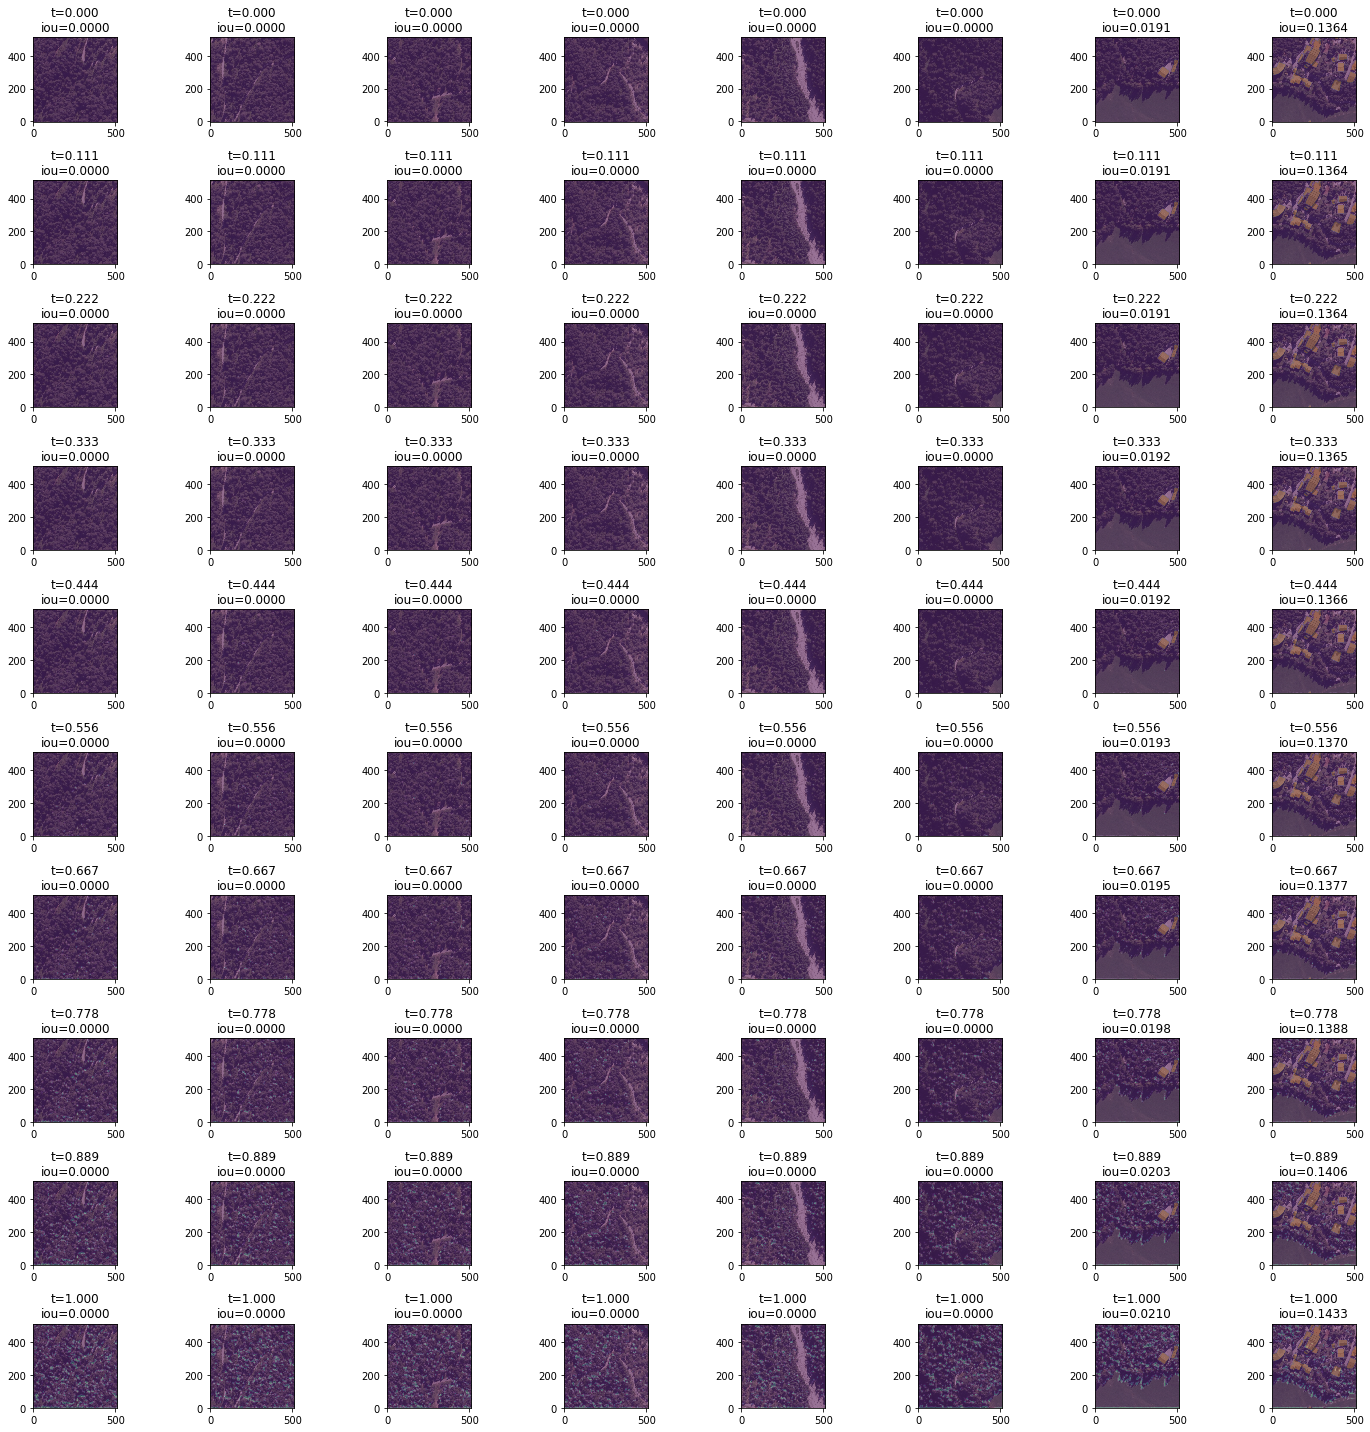

In [46]:
size = (10, batch_size)
fig, axs = plt.subplots(*size, figsize=(20, 20))

for y in range(size[1]):
    idx = y
    l = iter(np.linspace(0, 1, num=size[0]))
    for x in range(size[0]):
        t = next(l)
        mask_thr = (output[idx]>=t).float()
        loss_value = float(criterion(mask_thr, labels[idx]))
        iou_value = 1-loss_value
        axs[x, y].set_title(f't={t:.3f}\niou={iou_value:.4f}')
        plot_lineup(
            tensor_to_image(images[idx]),
            tensor_to_image(mask_thr),        
            tensor_to_image(labels[idx]),
            figsize=(10, 10), ax=axs[x, y])

fig.tight_layout()

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x14c8d7546e80>>
Traceback (most recent call last):
Exception ignored in:   File "/home/s0011/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x14c8d7546e80>>Exception ignored in: 
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x14c8d7546e80>>Traceback (most recent call last):
    
Traceback (most recent call last):
  File "/home/s0011/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in:     self._shutdown_workers()self._shutdown_workers()<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingD

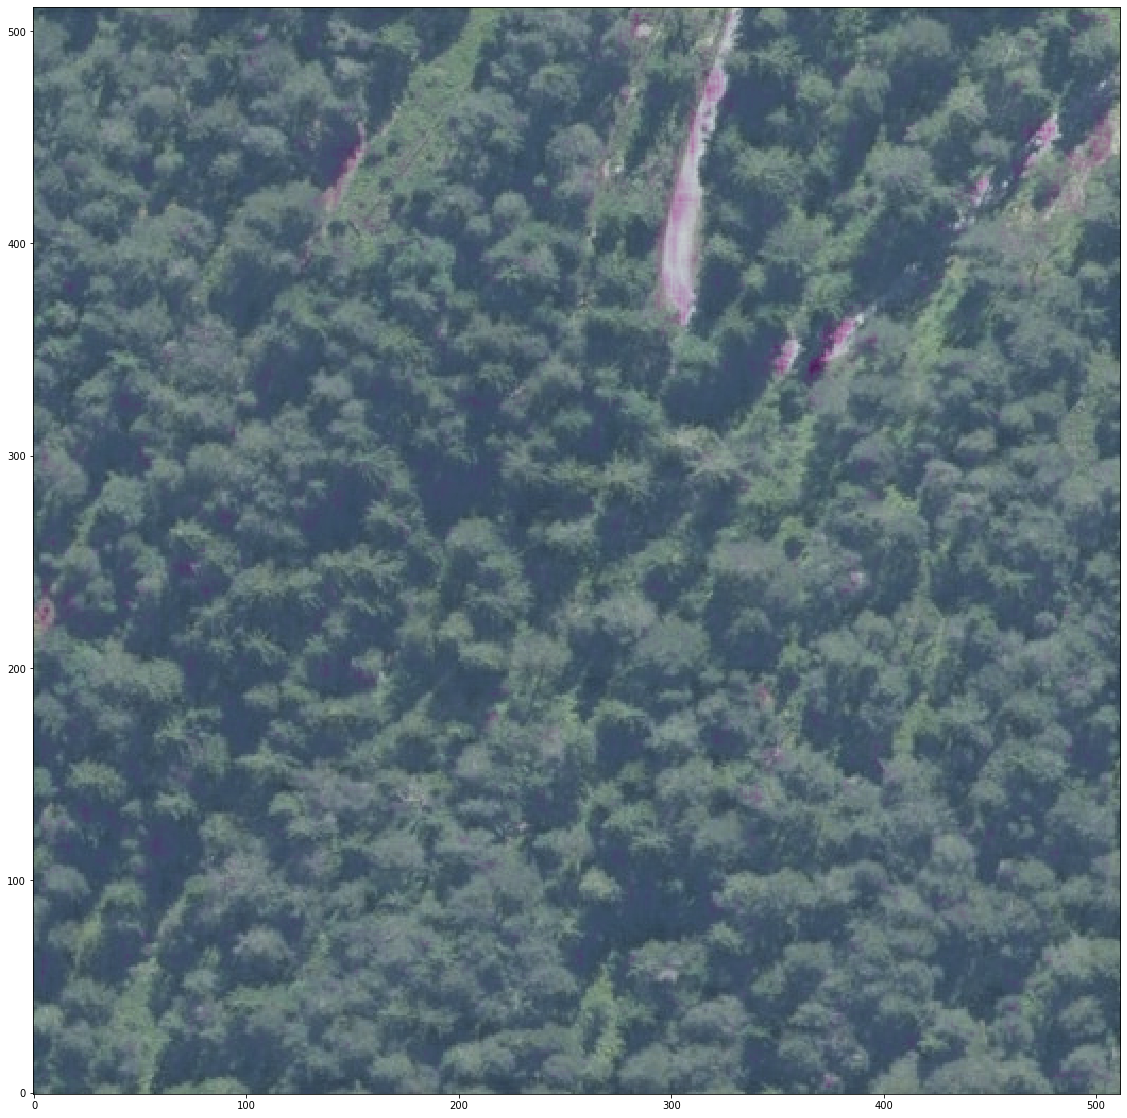

In [42]:
for x_batch, y_batch in test_dataloader:
    model.eval()
    with torch.no_grad():
        out = model(x_batch)
    plot_lineup(
        tensor_to_image(x_batch[0]), 
        tensor_to_image(out[0]), 
        tensor_to_image(y_batch[0]),
    )
    break

        